In [1]:
#https://www.kaggle.com/code/taronzakaryan/predicting-stock-price-using-lstm-model-pytorch
#https://bobrupakroy.medium.com/lstms-for-regression-cc9b6677697f
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from pylab import mpl, plt

import torch
import torch.nn as nn
import math

torch.manual_seed(8127)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Bear\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
import bs4 as bs
import requests
import yfinance as yf
import datetime

#We scrap from wikipedia the list of sp500 tickers to use for yahoo finance

resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '').replace('.','-') for s in tickers]

In [3]:
#Run this if needed. Download data from yahoo finance

#data_px = yf.download(tickers, data_source='yahoo', start = '2011-01-01', end = '2022-09-30',timeout=5)
#data_px.to_pickle('data_prices.pkl')


In [4]:
data_px=pd.read_pickle('data_prices.pkl')
data_px = data_px['Adj Close']
data_px = data_px.fillna(method='ffill')
data_px = data_px[data_px.index>='2010-01-03'] #Using data too long ago might not be wise. due to structural/regime change in financial markets.
data_px = data_px[data_px.index<'2022-10-01']
data_px = data_px[data_px.columns[(~np.isnan(data_px.iloc[0]))]]

test_set_size = int(np.round(0.2*data_px.shape[0]))
train_set_size = data_px.shape[0] - (test_set_size)   
data_px['dataset'] = [1 if x >=train_set_size else 0 for x in range(data_px.shape[0])]



In [71]:
#Generate price features
# Lag
# And Average Price (Typical CTA uses crossover strategy of different frequency)

data_px_features = None
for asset_i in range(data_px.shape[1]-1):
    
    temp = data_px.iloc[:,asset_i:asset_i+1].copy()
    temp.columns=['PX']
    temp['rtn'] = ((temp.iloc[:,0]/temp.iloc[:,0].transform(lambda x: x.shift(1)))-1)
    for i in (1,5,21,21*3,21*6,252):
        temp['lag_'+str(i)] = temp.iloc[:,0].transform(lambda x: x.shift(i))
        if (i==1):
            continue
        #temp['rolling_mean_'+str(i)] = temp.iloc[:,1].transform(lambda x: x.shift(28).rolling(i).mean())
        #temp['rolling_std_'+str(i)]  = temp.iloc[:,1].transform(lambda x: x.shift(28).rolling(i).std())
        temp['rolling_meanpx_'+str(i)] = temp.iloc[:,0].transform(lambda x: x.shift(28).rolling(i).mean())
    
    temp['dataset'] = data_px['dataset']
    temp['ticker'] = data_px.columns[asset_i]
    temp['date'] = data_px.iloc[:,asset_i:asset_i+1].index
    temp = temp.iloc[np.where(~temp.isnull().any(axis=1))[0][0]:]
    
    if data_px_features is None:
        data_px_features = temp
    else:
        data_px_features = pd.concat([data_px_features,temp],axis=0,ignore_index=True)
    print(data_px_features.shape)





(2677, 16)
(5354, 16)
(8031, 16)
(10708, 16)
(13385, 16)
(16062, 16)
(18739, 16)
(21416, 16)
(24093, 16)
(26770, 16)
(29447, 16)
(32124, 16)
(34801, 16)
(37478, 16)
(40155, 16)
(42832, 16)
(45509, 16)
(48186, 16)
(50863, 16)
(53540, 16)
(56217, 16)
(58894, 16)
(61571, 16)
(64248, 16)
(66925, 16)
(69602, 16)
(72279, 16)
(74956, 16)
(77633, 16)
(80310, 16)
(82987, 16)
(85664, 16)
(88341, 16)
(91018, 16)
(93695, 16)
(96372, 16)
(99049, 16)
(101726, 16)
(104403, 16)
(107080, 16)
(109757, 16)
(112434, 16)
(115111, 16)
(117788, 16)
(120465, 16)
(123142, 16)
(125819, 16)
(128496, 16)
(131173, 16)
(133850, 16)
(136527, 16)
(139204, 16)
(141881, 16)
(144558, 16)
(147235, 16)
(149912, 16)
(152589, 16)
(155266, 16)
(157943, 16)
(160620, 16)
(163297, 16)
(165974, 16)
(168651, 16)
(171328, 16)
(174005, 16)
(176682, 16)
(179359, 16)
(182036, 16)
(184713, 16)
(187390, 16)
(190067, 16)
(192744, 16)
(195421, 16)
(198098, 16)
(200775, 16)
(203452, 16)
(206129, 16)
(208806, 16)
(211483, 16)
(214160, 16)


In [72]:
data_px_features

,PX,rtn,lag_1,lag_5,rolling_meanpx_5,lag_21,rolling_meanpx_21,lag_63,rolling_meanpx_63,lag_126,rolling_meanpx_126,lag_252,rolling_meanpx_252,dataset,ticker,date
0,28.672152,-0.021069,29.289249,29.412666,22.697382,25.281387,22.687731,23.430096,22.897449,22.416771,23.912484,28.581207,26.883946,0,A,2012-02-10
1,28.477282,-0.006796,28.672152,29.009928,22.842886,25.671124,22.646282,23.943264,22.970449,23.521034,23.834226,29.243771,26.870026,0,A,2012-02-13
2,28.438311,-0.001368,28.477282,28.970963,22.965003,25.372320,22.628651,24.333008,23.023858,24.358990,23.753648,29.094370,26.856365,0,A,2012-02-14
3,28.347364,-0.003198,28.438311,29.211302,23.340457,25.976425,22.626795,24.391468,23.074174,23.793858,23.674359,27.704288,26.845023,0,A,2012-02-15
4,28.470785,0.004354,28.347364,29.289249,23.644456,26.807877,22.639786,24.846170,23.113973,23.254725,23.608216,28.301897,26.834506,0,A,2012-02-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201968,54.520000,-0.022063,55.750000,57.700001,56.629651,56.279999,53.836534,52.959343,53.065637,67.631958,58.219675,57.901459,60.065968,1,ZION,2022-09-23
1201969,53.529999,-0.018159,54.520000,58.380001,57.495590,57.310001,54.220513,52.244343,53.166934,70.097404,58.121145,58.769585,60.085382,1,ZION,2022-09-26
1201970,52.759998,-0.014384,53.529999,57.700001,58.029976,56.439999,54.526969,52.323788,53.238822,68.766068,58.008145,61.344719,60.107785,1,ZION,2022-09-27
1201971,53.270000,0.009666,52.759998,57.099998,58.417558,55.750000,54.807457,51.608791,53.336574,68.775917,57.896254,61.198410,60.133452,1,ZION,2022-09-28


In [287]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back,scaler=None,y_scaler=None):
        

    if scaler is None:
        print('Fitting X Scaler')
        scaler  = MinMaxScaler(feature_range=(-1, 1))
        scaler  = scaler.fit(stock[stock['dataset']==0].drop(['ticker','dataset','date'],axis=1).values)
    if y_scaler is None:
        print('Fitting Y Scaler')
        y_scaler  = MinMaxScaler(feature_range=(-1, 1))
        y_scaler = y_scaler.fit(stock.iloc[:,:1][stock['dataset']==0].values)

    scaled_data = scaler.transform(stock.drop(['ticker','dataset','date'],axis=1).values)
    scaled_y_data = y_scaler.transform(stock['PX'].values.reshape([-1,1]))


    total_look_back = look_back + oos_prediction_window

    x_train = None
    y_train = None
    x_test = None
    y_test = None


    #Because it is LSTM, we have to create rolling-window data
    for ticker in stock['ticker'].unique():

        stock_data = scaled_data[np.where(stock['ticker']==ticker)]
        train_test_indicator = stock[stock['ticker']==ticker]['dataset'].values[total_look_back:]
        print(ticker)


        data = []
        datay = []
        # create all possible sequences of length look_back
        for index in range(len(stock_data) - total_look_back): 
            data.append(stock_data[index: index + total_look_back])
            datay.append(scaled_y_data[index: index + total_look_back,:1])

        data = np.array(data)
        datay = np.array(datay)

        x_train_i = data[np.where(train_test_indicator==0)][:,range(0,look_back),:]    
        y_train_i = datay[np.where(train_test_indicator==0)][:,range(look_back,total_look_back),0]

        x_test_i = data[np.where(train_test_indicator==1)][:,range(0,look_back),:]        
        y_test_i = datay[np.where(train_test_indicator==1)][:,range(look_back,total_look_back),0]
        
        
        x_oos = data[np.where(train_test_indicator==1)][:,range(total_look_back-look_back,total_look_back),:]
        

        if x_train is None:
            x_train = x_train_i
            y_train = y_train_i
            x_test = x_test_i
            y_test = y_test_i
        else:
            x_train = np.vstack([x_train,x_train_i])
            y_train = np.vstack([y_train,y_train_i])
            x_test = np.vstack([x_test,x_test_i])
            y_test = np.vstack([y_test,y_test_i])
    
    #y_train = np.apply_along_axis(lambda x:((x[-1]/x[0])-1),1,y_train)
    #y_test = np.apply_along_axis(lambda x:((x[-1]/x[0])-1),1,y_test)

    
    return [x_train, y_train, x_test, y_test,x_oos,scaler,y_scaler]

look_back = 21*3 # choose sequence length
oos_prediction_window = 21 #Our returns forecast are 1 month ahead

x_train, y_train, x_test, y_test,x_oos,scaler,y_scaler = load_data(data_px_features, look_back)




Fitting X Scaler
Fitting Y Scaler
A
AAL
AAP
AAPL
ABC
ABMD
ABT
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALK
ALL
AMAT
AMD
AME
AMGN
AMP
AMT
AMZN
ANSS
AON
AOS
APA
APD
APH
ARE
ATO
ATVI
AVB
AVGO
AVY
AWK
AXP
AZO
BA
BAC
BALL
BAX
BBWI
BBY
BDX
BEN
BF-B
BIIB
BIO
BK
BKNG
BKR
BLK
BMY
BR
BRK-B
BRO
BSX
BWA
BXP
C
CAG
CAH
CAT
CB
CBOE
CBRE
CCI
CCL
CDNS
CE
CF
CHD
CHRW
CHTR
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COST
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTRA
CTSH
CVS
CVX
D
DAL
DD
DE
DFS
DG
DGX
DHI
DHR
DIS
DISH
DLR
DLTR
DOV
DPZ
DRI
DTE
DUK
DVA
DVN
DXC
DXCM
EA
EBAY
ECL
ED
EFX
EIX
EL
ELV
EMN
EMR
EOG
EQIX
EQR
EQT
ES
ESS
ETN
ETR
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FAST
FCX
FDS
FDX
FE
FFIV
FIS
FISV
FITB
FLT
FMC
FRC
FRT
FTNT
GD
GE
GILD
GIS
GL
GLW
GM
GNRC
GOOG
GOOGL
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HD
HES
HIG
HOLX
HON
HPQ
HRL
HSIC
HST
HSY
HUM
IBM
ICE
IDXX
IEX
IFF
ILMN
INCY
INTC
INTU
IP
IPG
IRM
ISRG
IT
ITW
IVZ
J
JBHT
JCI
JKHY
JNJ
JNPR
JPM
K
KDP
KEY
KIM
KLAC
KMB
KMX
KO
KR

MemoryError: Unable to allocate 3.55 GiB for an array with shape (582582, 63, 13) and data type float64

In [9]:
x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)
y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
y_test = torch.from_numpy(y_test).type(torch.Tensor).to(device)



print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  torch.Size([898898, 63, 13])
y_train.shape =  torch.Size([898898, 21])
x_test.shape =  torch.Size([265359, 63, 13])
y_test.shape =  torch.Size([265359, 21])


In [49]:
#Add in macro variables
#These are forward looking indicators that may increase predictive power

#https://www.clevelandfed.org/indicators-and-data/inflation-nowcasting
data_macro = pd.read_csv('data_cpi_nc_all.csv')[['obs_date','CCPI_INFLATION_YoY','CPI_INFLATION_YoY']]
data_macro.columns=['Date','CCPI_INFLATION_YoY','CPI_INFLATION_YoY']

#https://en.macromicro.me/charts/3997/global-ofr-fsi
data_macro2 = pd.read_csv('data_ofr_all.csv')[['obs_date','ofr_usa','ofr_otherdm','ofr_em']]
data_macro2.columns=['Date','FSI_USA','FSI_DM','FSI,EM']

#https://en.macromicro.me/charts/22907/sp-sector-performance
data_macro3 = pd.read_csv('data_sp_all.csv')
data_macro3 = data_macro3[['obs_date']+list(data_macro3.columns[:-1][1:])]
data_macro3.columns = ['Date']+list(['SEC_'+s for s in data_macro3.columns[1:].str.upper()])

data_macro = pd.merge(data_macro,data_macro2,on="Date",how="outer")
data_macro = pd.merge(data_macro,data_macro3,on="Date",how="outer")
data_macro = data_macro[data_macro['Date']>='2014-01-03']
data_macro = data_macro.sort_values('Date')

data_macro = pd.merge(data_macro,pd.DataFrame({'Date':list(data_px.index.strftime('%Y-%m-%d'))}),on="Date",how="right")

data_macro = data_macro.fillna(method='ffill')
data_macro.index = pd.to_datetime(data_macro['Date'])
del data_macro['Date']

# Step 1. Global Trend Model
## Train a universal Price Trend LSTM

Stock price is noisy , low signal to noise data. In order to do well, we need more sophisticated models.

We know that those toy-model LSTM can hardly beat an AR(1) model which simply use the last price as best prediction. So we need to innovate a bit.

Our approach is 
1. Train a universal price trend LSTM (leveraging other stocks as additional data) that learns global trend features
2. Augment macro economics data and fine-tune it for each individual stock as a mixed model setup (MLP plus LSTM)

We predict multi-step prices for 21 days (1 month of trading days). We designed a custom MAE which gives more weight to data further out as they are harder to predict

This is Step 1

In [10]:
from torch.utils.data import DataLoader, TensorDataset
BATCH_SIZE = 256
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)



## <font color='red'>Note: I haven really hyper-parameter tunned the hidden_dim and num_layers. ideally would be nice to do a grid search</font>

In [15]:
# Build model
#####################
input_dim = x_train.shape[2]
hidden_dim = 312 #Can tune this
num_layers = 2 # And can tune this

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,dropout=0.4).to(device)

        # Readout layer
        self.fc = nn.Linear(hidden_dim,32).to(device)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 21).to(device)
        

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        
        #print(f'h0 size = {h0.size()}')

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        #print(f'c0 size = {c0.size()}')


        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.fc2(out)
        # out.size() --> 100, 10
        return out
    
    
#Our custom error function
def custom_weight_mae(output, target):
    
    wgt = (torch.arange(1,22)/torch.arange(1,22).sum()).to(device)
    

    loss = torch.matmul((torch.abs((output - target))),wgt).mean()
    return loss


    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers)
model.to(device)


print(model)


LSTM(
  (lstm): LSTM(13, 312, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Linear(in_features=312, out_features=32, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=32, out_features=21, bias=True)
)


In [16]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Train model
#####################

optimiser = torch.optim.RAdam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimiser, 'min',factor=0.5,patience=3,min_lr =1e-8)

num_epochs = 20
hist = np.zeros(num_epochs)
hist_val = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    model.train()
    for id_batch, (x_batch, y_batch) in enumerate(dataloader):
        
        # Forward pass
        y_train_pred = model(x_batch)
        loss = custom_weight_mae(y_train_pred, y_batch)
        del y_train_pred
        
        
        hist[t] += loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1) #Prevent exploding gradient

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
        # Every 100 batches, print the loss for this batch
        # as well as the number of examples processed so far 
        if id_batch % 100 == 0:
            loss, current =  hist[t]/(id_batch+1), (id_batch + 1)* len(x_batch)
            print(f"Epoch {t}. Cumulative Train loss: {loss:>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")        
        
    
    
    hist[t]/=(id_batch+1)
    
    torch.cuda.empty_cache()
    
    
    #Compute validation loss
    model.eval()
    val_loss =0
    for id_batch, (x_batch, y_batch) in enumerate(dataloader_test):
        y_test_pred = model(x_batch)
        hist_val[t] += custom_weight_mae(y_test_pred, y_batch)
        del y_test_pred
    
    hist_val[t]/=(id_batch+1)
    print("Epoch ", t, "TRAIN-MSE: ", hist[t]," VAL-MSE:",hist_val[t],f" Best Val-MSE {np.min(hist_val[t])}   LR:",optimiser.param_groups[0]['lr'])

    # Update Scheduler
    scheduler.step(val_loss)

Epoch 0. Cumulative Train loss: 0.963975  [  256/898898]
Epoch 0. Cumulative Train loss: 0.947327  [25856/898898]
Epoch 0. Cumulative Train loss: 0.742968  [51456/898898]
Epoch 0. Cumulative Train loss: 0.569034  [77056/898898]
Epoch 0. Cumulative Train loss: 0.462472  [102656/898898]
Epoch 0. Cumulative Train loss: 0.388156  [128256/898898]
Epoch 0. Cumulative Train loss: 0.330877  [153856/898898]
Epoch 0. Cumulative Train loss: 0.286469  [179456/898898]
Epoch 0. Cumulative Train loss: 0.252218  [205056/898898]
Epoch 0. Cumulative Train loss: 0.225187  [230656/898898]
Epoch 0. Cumulative Train loss: 0.203549  [256256/898898]
Epoch 0. Cumulative Train loss: 0.185802  [281856/898898]
Epoch 0. Cumulative Train loss: 0.171024  [307456/898898]
Epoch 0. Cumulative Train loss: 0.158513  [333056/898898]
Epoch 0. Cumulative Train loss: 0.147788  [358656/898898]
Epoch 0. Cumulative Train loss: 0.138479  [384256/898898]
Epoch 0. Cumulative Train loss: 0.130334  [409856/898898]
Epoch 0. Cumulativ

KeyboardInterrupt: 

In [17]:
torch.save(model.state_dict(),'models/lstmv3.pth') #This saves the global model

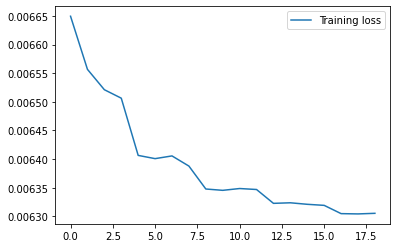

In [26]:
plt.plot(hist[1:20], label="Training loss")
plt.legend()
plt.show()

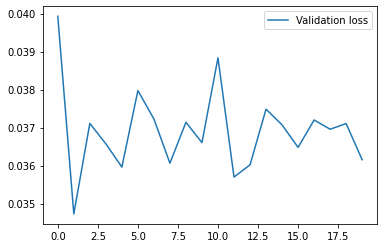

In [24]:
plt.plot(hist_val[:20], label="Validation loss")
plt.legend()
plt.show()

# Step 2: Individual-Asset Forecasting
### Fine-tune for each individual asset, including macro-variablesdata_px_features and make prediction

In [300]:
del model

NameError: name 'model' is not defined

In [301]:
del dataset

In [302]:
del dataset_test

Note: This is step 2. Our asset specific mixed-model that is fine-tuned from the global LSTM

In [165]:
# Here we define our model as a class
class MixedModel(nn.Module):
    def __init__(self):
        super(MixedModel, self).__init__()

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.internal_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers).to(device)
        self.internal_lstm.load_state_dict(torch.load('models/lstmv3.pth'))

        # Readout layer
        self.macrol1 = nn.Linear(16,32).to(device)
        self.do = nn.Dropout(p=0.2)
        self.mrelu = nn.ReLU()
        self.fc = nn.Linear(21+32,128).to(device)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 21).to(device)
        

    def forward(self, x):


        lstm_out = self.internal_lstm(x_train[:,:,0:13])
        macro_out = self.macrol1(x_train[:,-1,13:])
        macro_out  = self.mrelu(macro_out)
        macro_out = self.do(macro_out)
        
        #print(lstm_out.shape)
        #print(macro_out.shape)
        
        combined_output = torch.hstack([lstm_out,macro_out])
        
        out = self.fc(combined_output)
        out = self.relu(out)
        out = self.fc2(out)

        return out
    

In [309]:
m_scaler  = MinMaxScaler(feature_range=(-1, 1))
m_scaled_macro = m_scaler.fit_transform(data_macro[data_macro.index>='2014-01-03'].values) #Macro data unfortuantely starts from 2014
m_scaled_macro = pd.DataFrame(m_scaled_macro)
m_scaled_macro.index = data_macro.index[data_macro.index>='2014-01-03']
m_scaled_macro.columns=data_macro.columns

asset_predicted_returns = {}

for tic in data_px_features['ticker'].unique():
    
    model_i = MixedModel()
    model_i.to(device)
    optimiser = torch.optim.RAdam(model_i.parameters(), lr=1e-2)


    
    data_i = data_px_features[data_px_features['ticker']==tic]
    data_i.index = data_i['date']
    data_i = pd.merge(data_i,m_scaled_macro,how='left',left_index=True,right_index=True)
    data_i = data_i[data_i.index>='2014-01-03']
    data_i = data_i.fillna(method='ffill')

    
    x_train, y_train, x_test, y_test,x_oos,scaler_i,y_scaler_i = load_data(data_i, look_back)
    
    x_train = np.vstack([x_train,x_test])
    y_train = np.vstack([y_train,y_test])
    
    x_train = torch.from_numpy(x_train).type(torch.Tensor).to(device)
    y_train = torch.from_numpy(y_train).type(torch.Tensor).to(device)
    x_oos = torch.from_numpy(x_oos).type(torch.Tensor).to(device)


    n_epochs_asset_i = 50   #I dont know if 50 is the best. could be improved through grid search
    train_error = np.zeros(n_epochs_asset_i)
    
    for t in range(n_epochs_asset_i):

        # Forward pass
        model_i.train()
        y_train_pred = model_i(x_train)
        loss = custom_weight_mae(y_train_pred, y_train)

        
        
        train_error[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
        
        torch.nn.utils.clip_grad_norm_(model_i.parameters(), 1) #Prevent exploding gradient

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
        model_i.eval()
        oos_pred = model_i(x_oos)
        predicted_prices = y_scaler_i.inverse_transform(oos_pred[-1,].cpu().detach().numpy().reshape(-1,1))
        predicted_returns = (predicted_prices[-1]/predicted_prices[0])[0]-1
    
        
        print(f"Asset {tic} Epoch {t}. Cumulative Train loss: {loss:>7f}. Predicted Returns {predicted_returns*100}")
    

    asset_predicted_returns[tic] = predicted_returns
    

    del x_train
    del x_test
    del model_i
    del y_train_pred
    
    



Fitting X Scaler
Fitting Y Scaler
A
Asset A Epoch 0. Cumulative Train loss: 1.049787. Predicted Returns -15.723323822021484
Asset A Epoch 1. Cumulative Train loss: 1.048477. Predicted Returns -15.386766195297241
Asset A Epoch 2. Cumulative Train loss: 1.047957. Predicted Returns -15.051436424255371
Asset A Epoch 3. Cumulative Train loss: 1.046731. Predicted Returns -14.71484899520874
Asset A Epoch 4. Cumulative Train loss: 1.045558. Predicted Returns -14.381015300750732
Asset A Epoch 5. Cumulative Train loss: 1.045363. Predicted Returns -13.503450155258179
Asset A Epoch 6. Cumulative Train loss: 1.039918. Predicted Returns -12.455356121063232
Asset A Epoch 7. Cumulative Train loss: 1.034111. Predicted Returns -11.320990324020386
Asset A Epoch 8. Cumulative Train loss: 1.027482. Predicted Returns -10.096985101699829
Asset A Epoch 9. Cumulative Train loss: 1.021328. Predicted Returns -8.755946159362793
Asset A Epoch 10. Cumulative Train loss: 1.013697. Predicted Returns -7.43970870971679

In [307]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [310]:
asset_predicted_returns

{'A': -0.058078110218048096,
 'AAL': 0.3072700500488281,
 'AAP': 0.045207977294921875,
 'AAPL': 0.1261991262435913,
 'ABC': 0.02419877052307129,
 'ABMD': -0.036672770977020264,
 'ABT': 0.012738704681396484,
 'ACN': 0.12128269672393799,
 'ADBE': -0.001069188117980957,
 'ADI': -0.018438339233398438,
 'ADM': 0.055796265602111816,
 'ADP': 0.06156635284423828,
 'ADSK': -0.061473548412323,
 'AEE': 0.03014373779296875,
 'AEP': 0.01991283893585205,
 'AES': -0.014042377471923828,
 'AFL': -0.06974607706069946,
 'AIG': -0.01619809865951538,
 'AIZ': -0.005583345890045166,
 'AJG': 0.16414999961853027,
 'AKAM': -0.03802454471588135,
 'ALB': -0.04074501991271973,
 'ALGN': -0.02168595790863037,
 'ALK': -0.024254262447357178,
 'ALL': 0.008684873580932617,
 'AMAT': -0.06688851118087769,
 'AMD': 0.0016912221908569336,
 'AME': -0.0315241813659668,
 'AMGN': 0.06556820869445801,
 'AMP': 0.07679212093353271,
 'AMT': 0.020978212356567383,
 'AMZN': 0.048592448234558105,
 'ANSS': 0.030457615852355957,
 'AON': -

In [ ]:
import json

json.dumps(asset_predicted_returns,)